In [1]:
from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

import joblib

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

NOTEBOOK_DIR = Path("")

ARTIFACTS_DIR = NOTEBOOK_DIR / "artifacts"
FIGURES_DIR = ARTIFACTS_DIR / "figures"

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("Notebook dir:", NOTEBOOK_DIR.resolve())
print("Artifacts dir:", ARTIFACTS_DIR.resolve())

Notebook dir: /mnt/e/PyCharmProjects/aie-seminars/homeworks/HW06
Artifacts dir: /mnt/e/PyCharmProjects/aie-seminars/homeworks/HW06/artifacts


In [3]:
def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
        "roc_auc": None,
    }
    try:
        m["roc_auc"] = float(roc_auc_score(y_true, y_pred)) if y_proba is not None else None
    except Exception as e:
        print("Error computing ROC AUC:", e)
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.savefig(FIGURES_DIR / f"{title}_confusion_matrix.png")
    plt.show()

def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        raise AttributeError("Model does not support predict_proba")
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.savefig(FIGURES_DIR / f"{title}_ROC.png")
    plt.show()

def plot_pr(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        raise AttributeError("Model does not support predict_proba")
    y_proba = model.predict_proba(X_test)[:, 1]
    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(title)
    plt.savefig(FIGURES_DIR / f"{title}_PRC.png")
    plt.show()

In [4]:
data = pd.read_csv(NOTEBOOK_DIR / "S06-hw-dataset-04.csv", index_col=0, converters={'target': lambda x: bool(int(x.strip()))})
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 1 to 25000
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f01     25000 non-null  float64
 1   f02     25000 non-null  float64
 2   f03     25000 non-null  float64
 3   f04     25000 non-null  float64
 4   f05     25000 non-null  float64
 5   f06     25000 non-null  float64
 6   f07     25000 non-null  float64
 7   f08     25000 non-null  float64
 8   f09     25000 non-null  float64
 9   f10     25000 non-null  float64
 10  f11     25000 non-null  float64
 11  f12     25000 non-null  float64
 12  f13     25000 non-null  float64
 13  f14     25000 non-null  float64
 14  f15     25000 non-null  float64
 15  f16     25000 non-null  float64
 16  f17     25000 non-null  float64
 17  f18     25000 non-null  float64
 18  f19     25000 non-null  float64
 19  f20     25000 non-null  float64
 20  f21     25000 non-null  float64
 21  f22     25000 non-null  float64
 22  f23

In [5]:
data.head()

,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
id,,,,,,,,,,,,,,,,,,,,,
1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,-1.857165,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,False
2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,-0.009307,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,False
3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,-4.966481,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,False
4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,0.291916,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,False
5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,-0.849466,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,False


In [6]:
data.describe()

,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,-0.000386,-0.004872,0.003202,0.335329,-0.000563,-0.010118,0.001182,0.957385,-0.004658,-0.051834,...,-0.000535,-0.166251,-3.387506,1.749793,-0.013017,-0.001383,0.893365,-0.909479,0.000570,-0.000754
std,1.001623,0.995606,1.004367,3.207537,0.993965,1.002172,2.432162,1.830223,1.013470,3.685062,...,1.001149,4.234741,4.331576,5.318660,1.001594,0.996409,2.445185,1.962618,0.994320,0.997167
min,-4.370993,-4.087073,-4.103875,-13.249937,-4.118778,-3.895974,-8.883224,-8.132548,-4.068933,-18.631100,...,-4.065387,-20.021141,-18.332290,-20.336666,-4.349216,-4.119472,-9.508509,-7.919287,-4.038312,-3.812255
25%,-0.680165,-0.675100,-0.675426,-1.750048,-0.669764,-0.674374,-1.647977,-0.217260,-0.688278,-2.440931,...,-0.687840,-2.897904,-6.278403,-1.775889,-0.689962,-0.676191,-0.735473,-2.226959,-0.666367,-0.665861
50%,0.001859,-0.000247,0.013272,0.403483,-0.001309,-0.005994,-0.011349,0.963009,0.000414,0.001875,...,0.001558,-0.396946,-3.462072,1.931851,-0.020933,-0.004193,0.888535,-0.923354,0.004381,0.002420
75%,0.679702,0.659523,0.683437,2.486453,0.672299,0.652629,1.658680,2.167758,0.681040,2.400587,...,0.680913,2.344956,-0.578540,5.473886,0.661300,0.673722,2.516790,0.395648,0.666474,0.665918
max,4.208888,3.984564,3.793442,15.288250,4.020733,4.279607,9.538525,9.321099,4.261349,14.680842,...,3.712112,20.717964,18.818764,20.688069,4.338337,3.902131,11.880651,6.778980,3.834922,4.012639


In [7]:
data.shape

(25000, 61)

In [8]:
# is 'target' is boolean? Yeah, it is. Used converters above to state it.
data['target'].value_counts()

target
False    23770
True      1230
Name: count, dtype: int64

In [9]:
# is there any missing values?
sum(data.isnull().sum().to_list())

0

In [10]:
data["target"].value_counts(normalize=True)

target
False    0.9508
True     0.0492
Name: proportion, dtype: float64

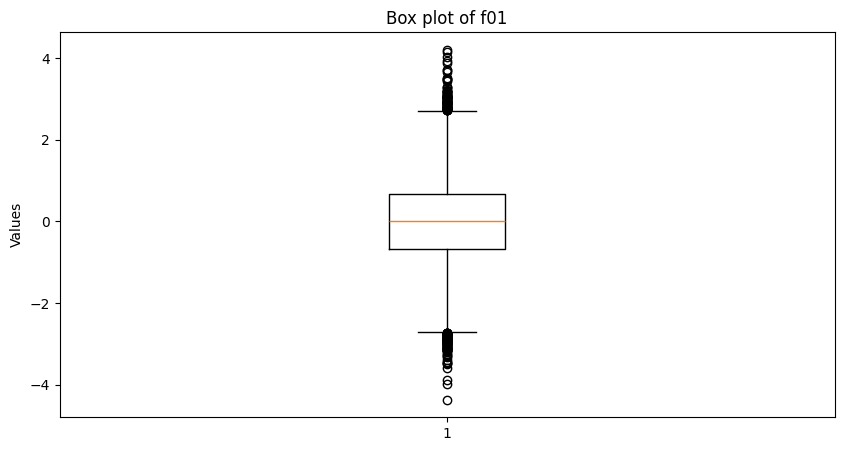

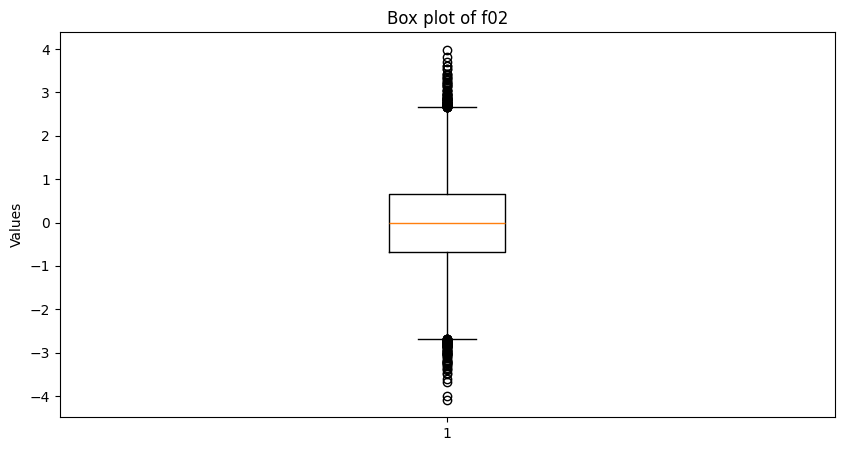

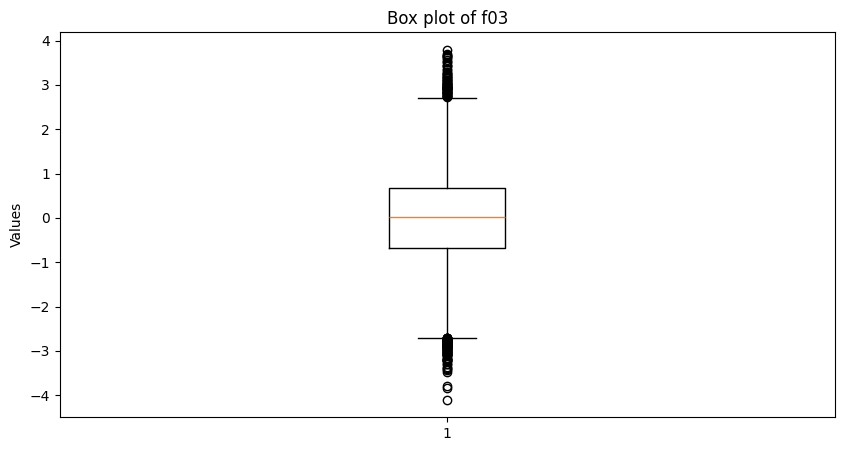

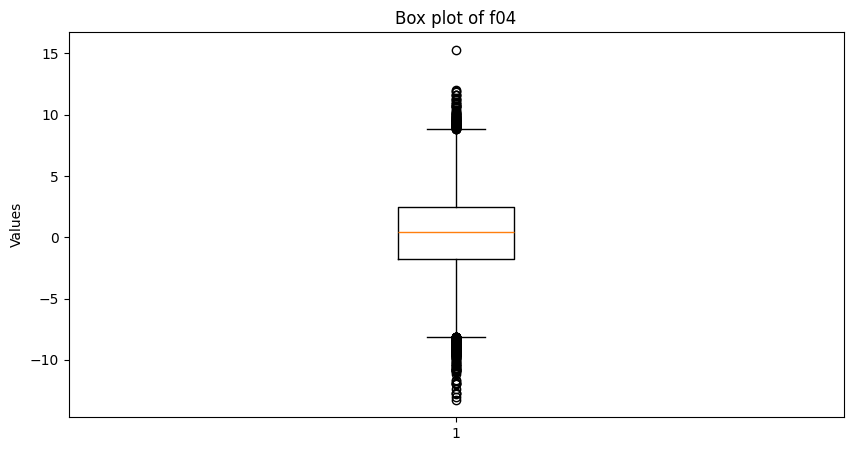

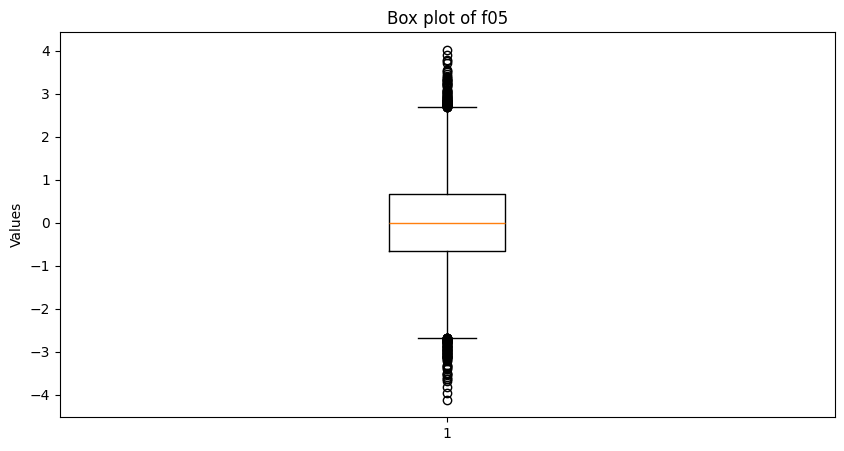

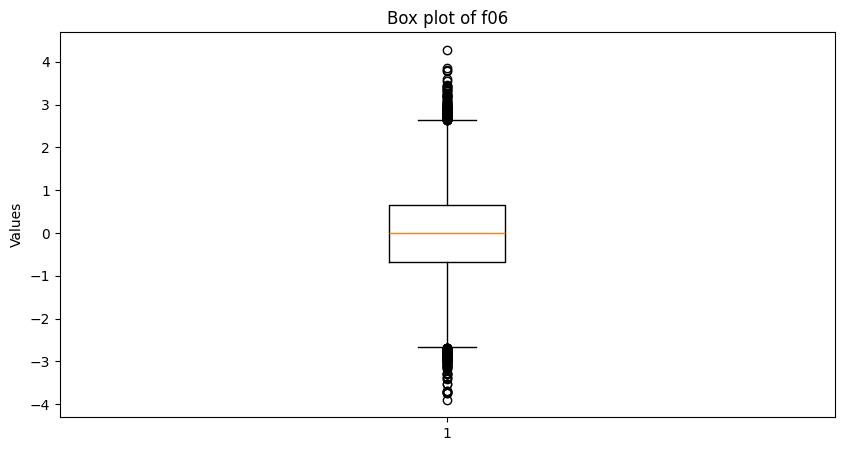

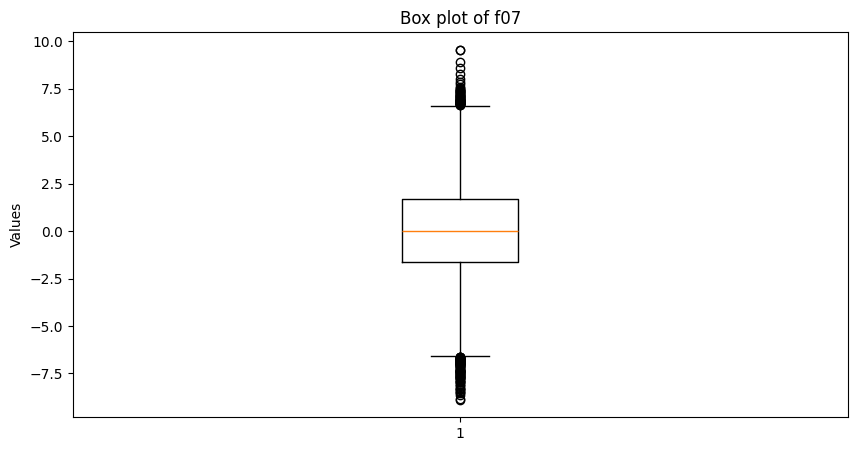

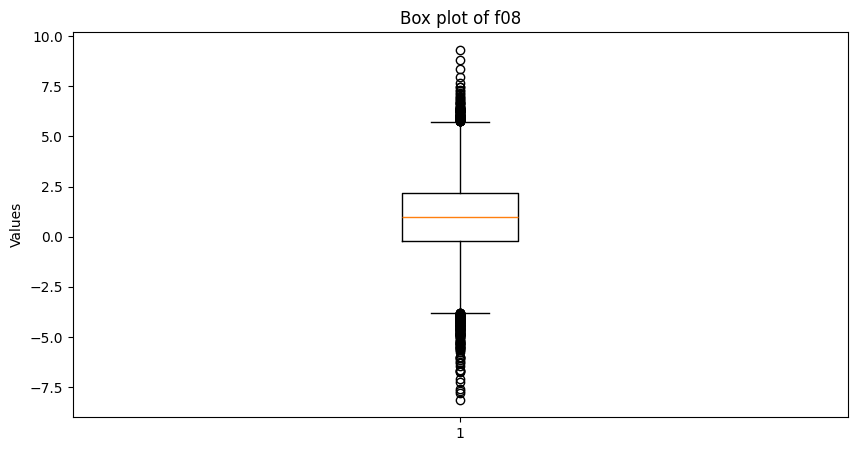

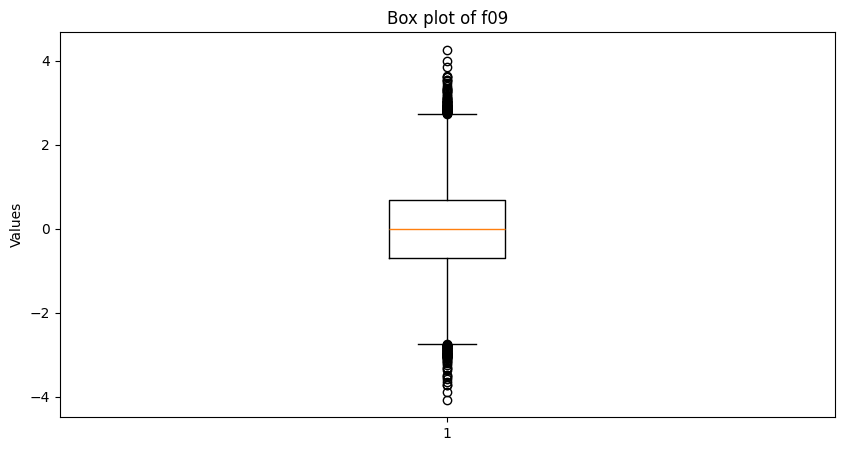

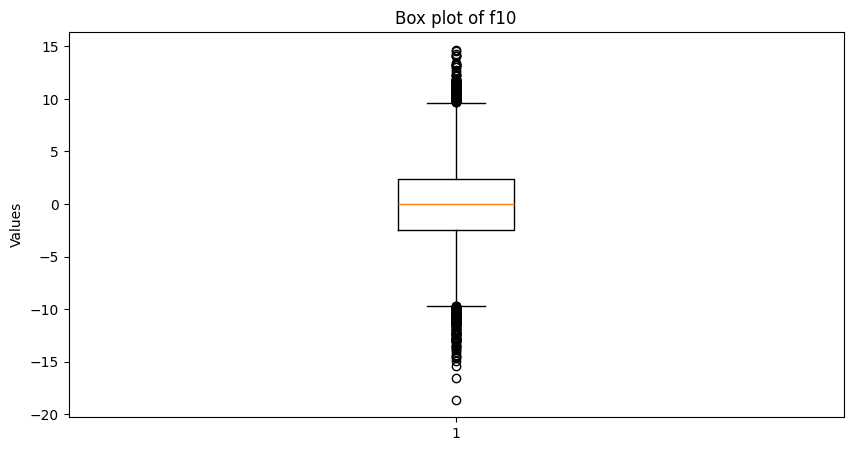

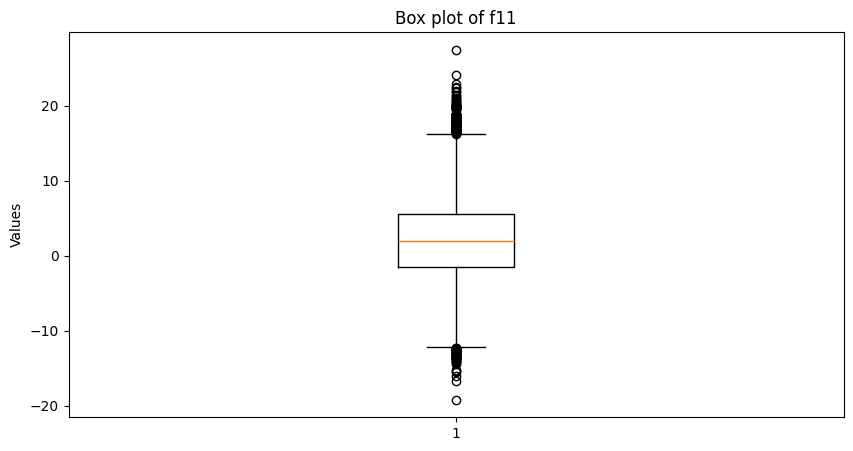

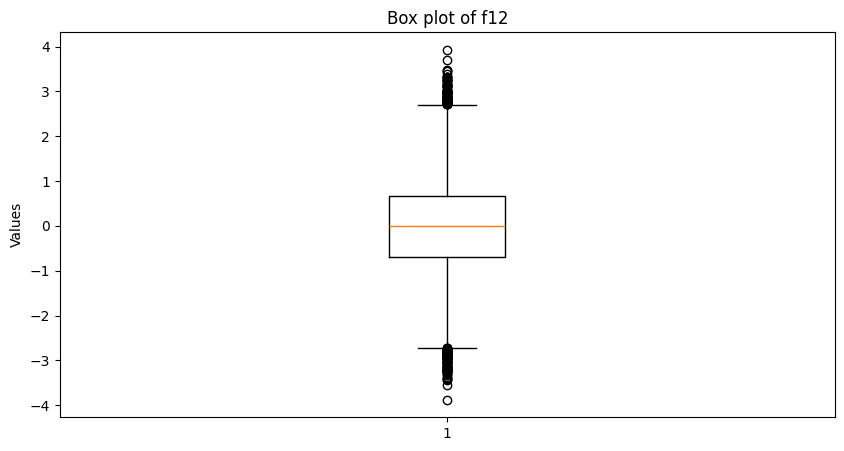

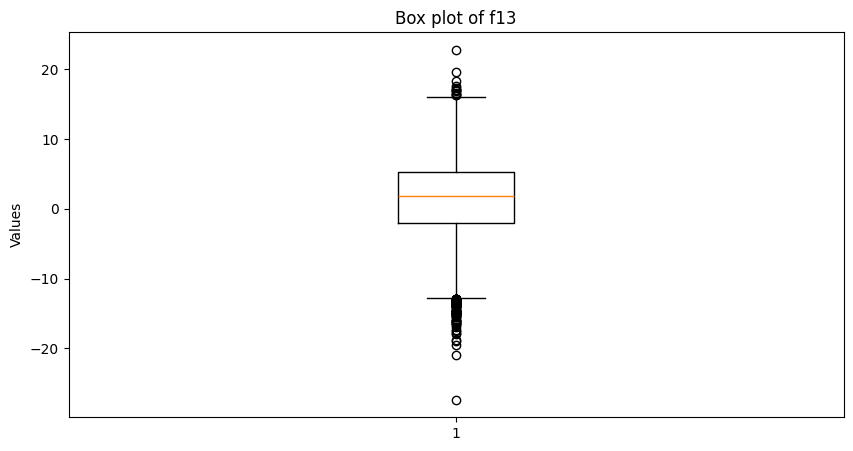

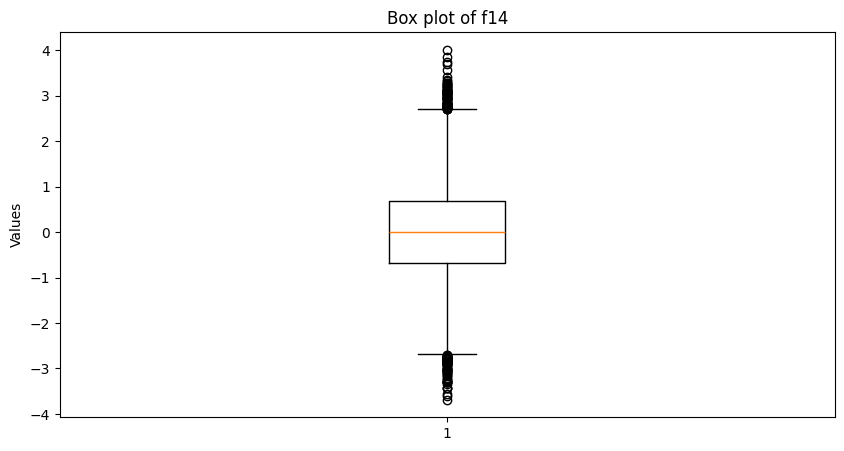

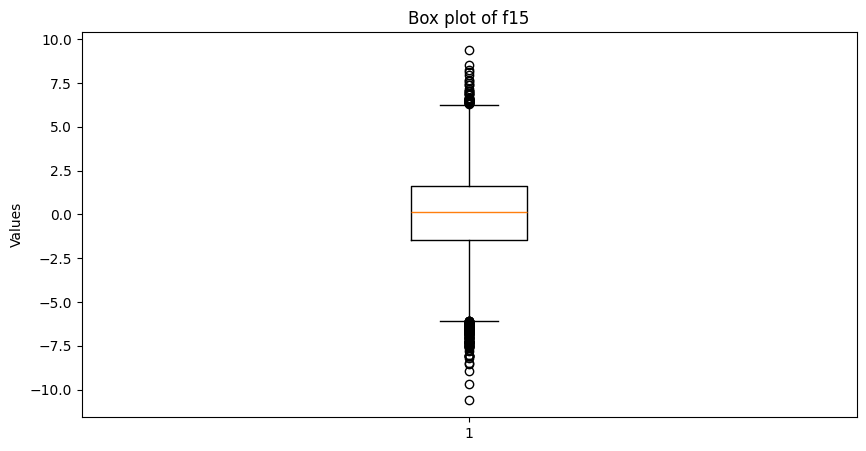

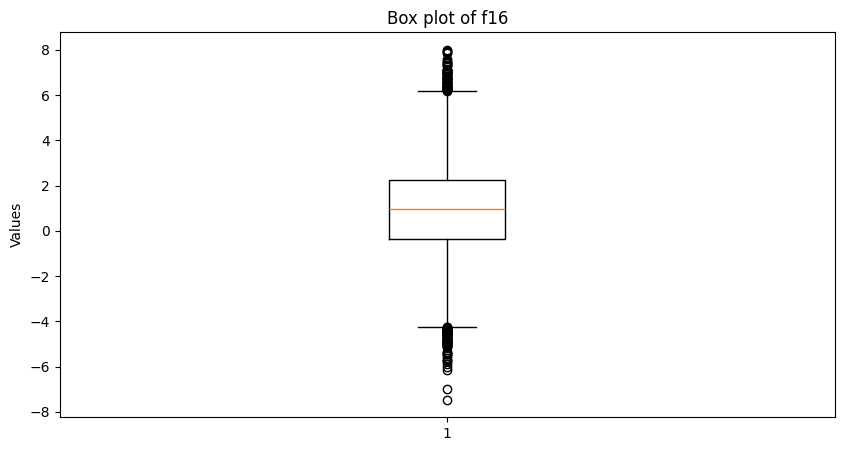

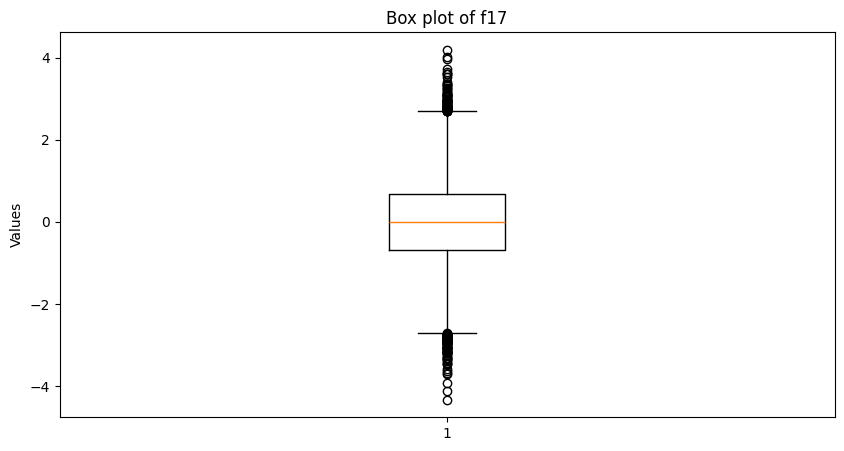

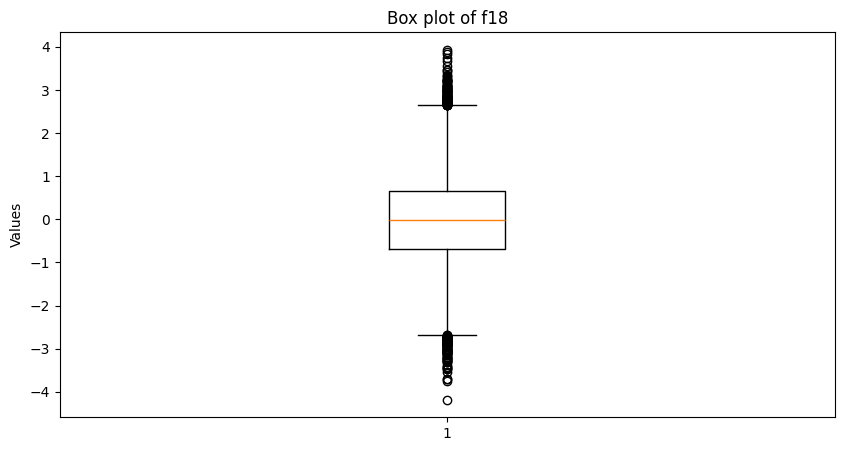

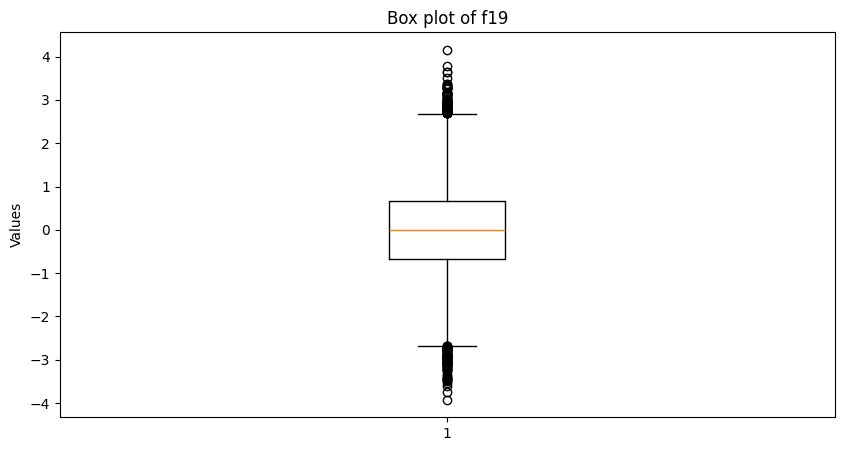

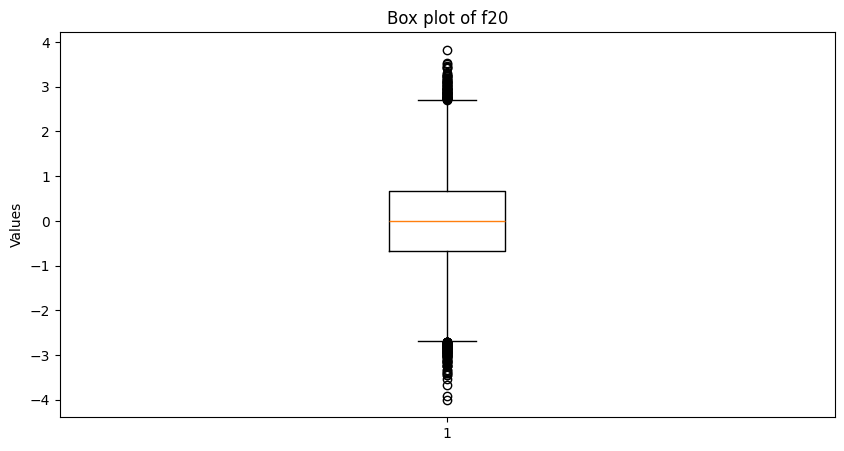

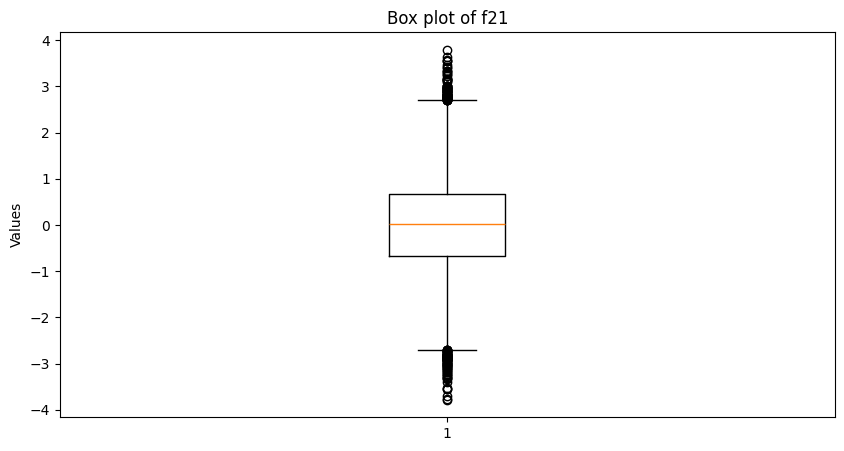

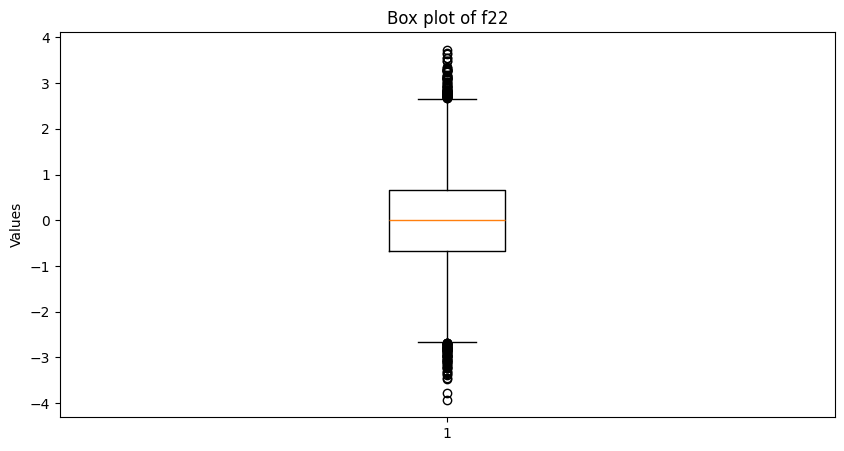

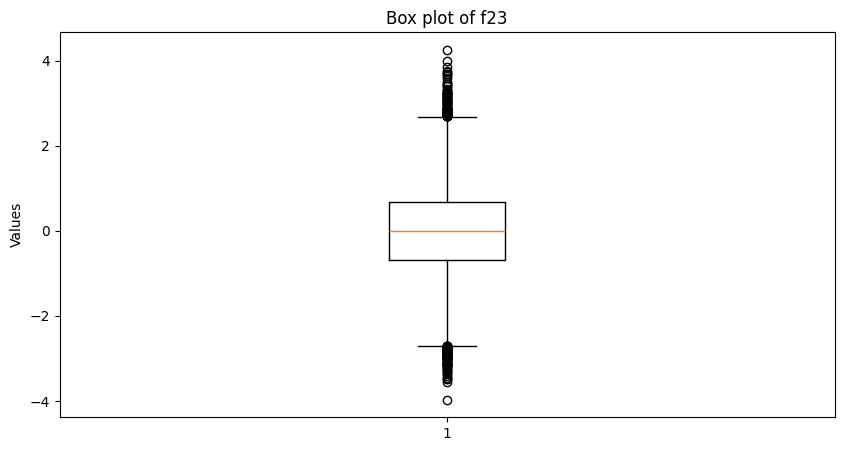

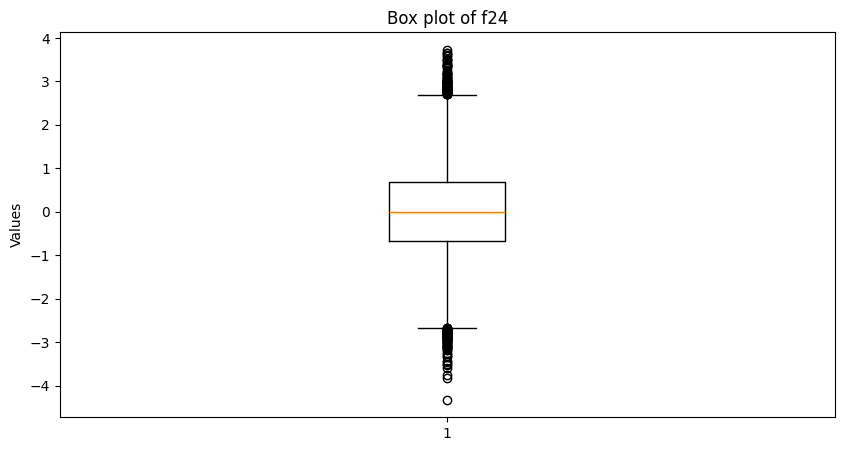

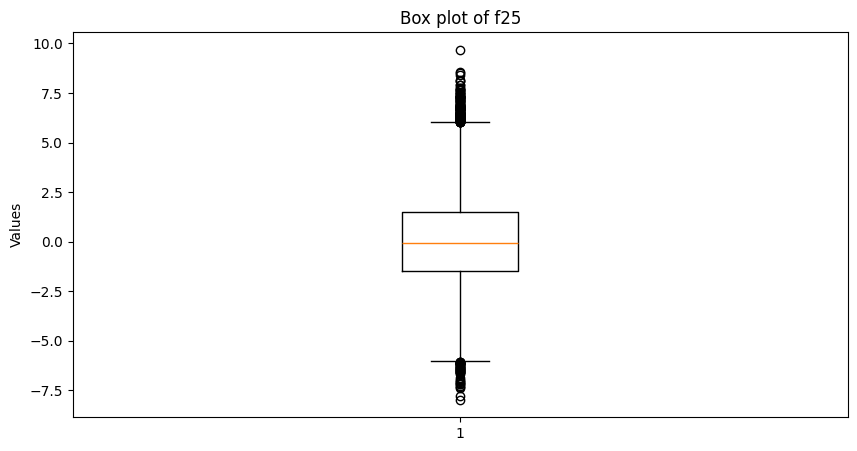

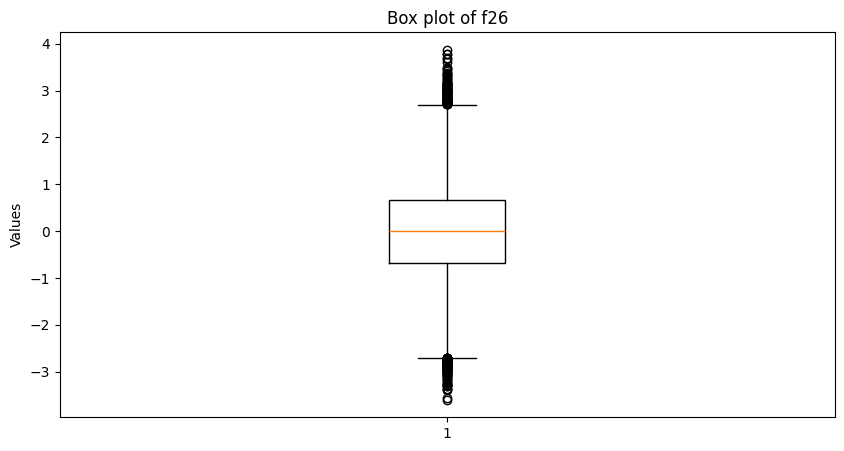

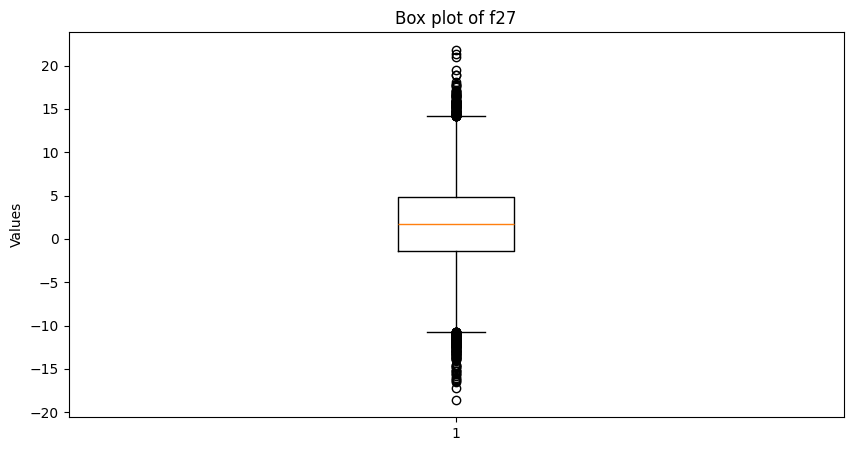

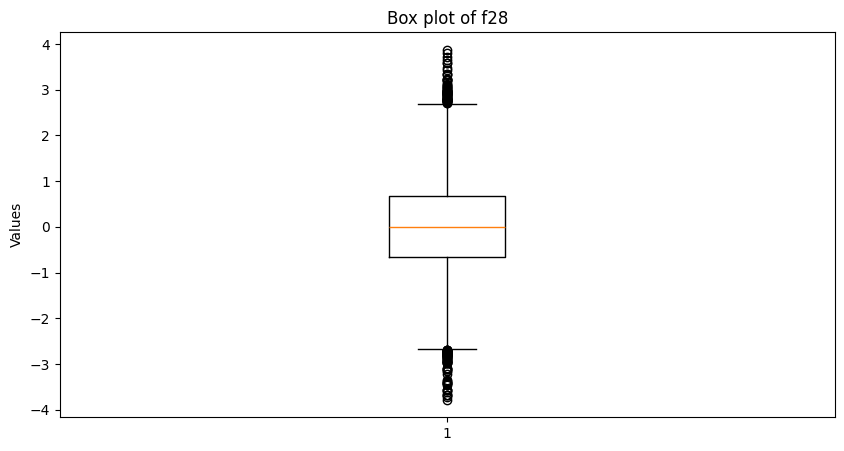

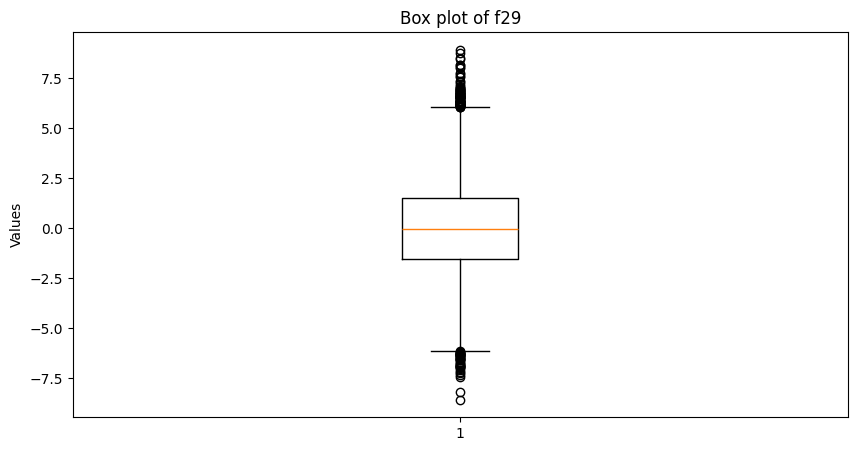

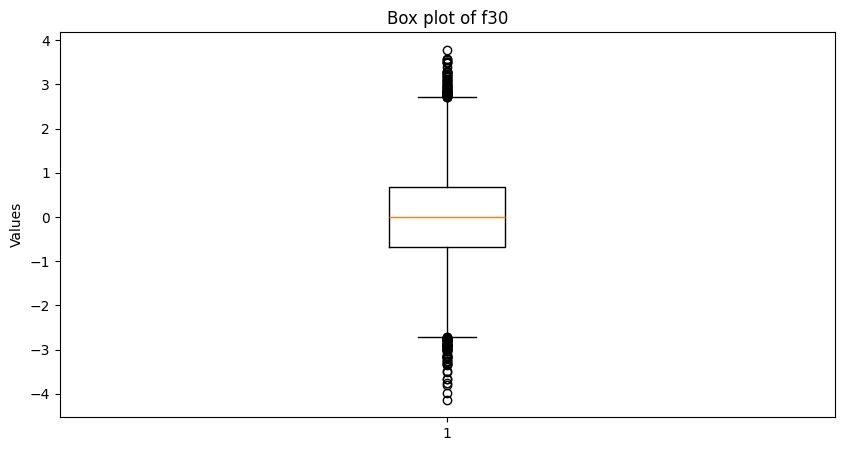

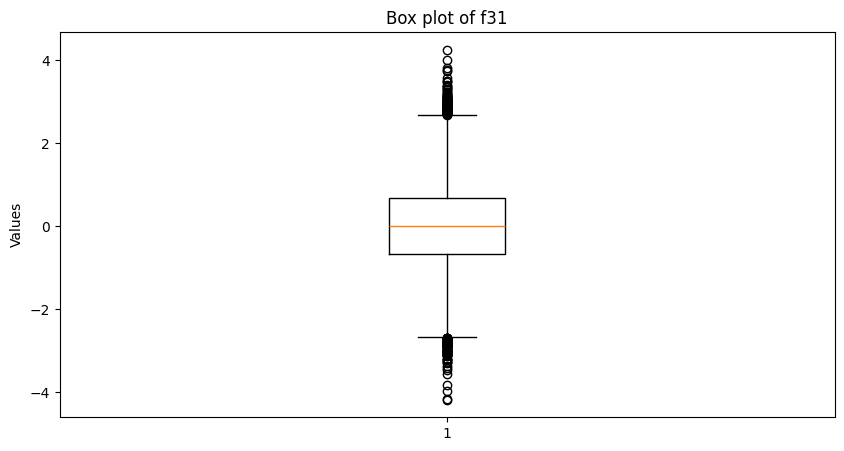

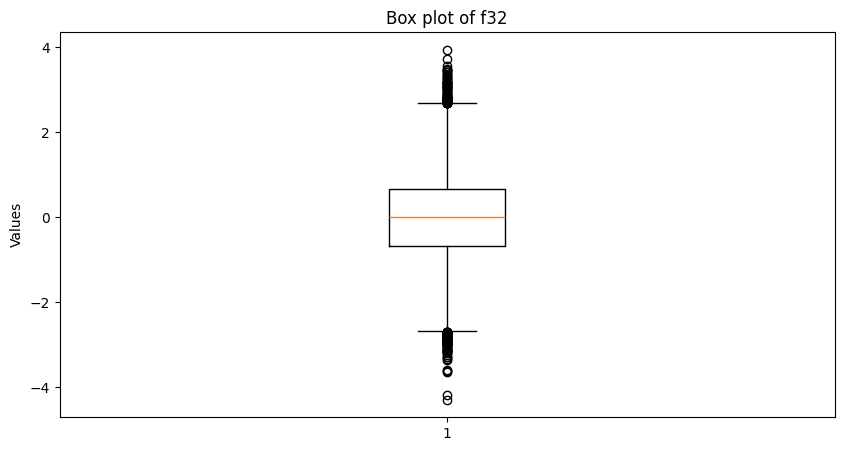

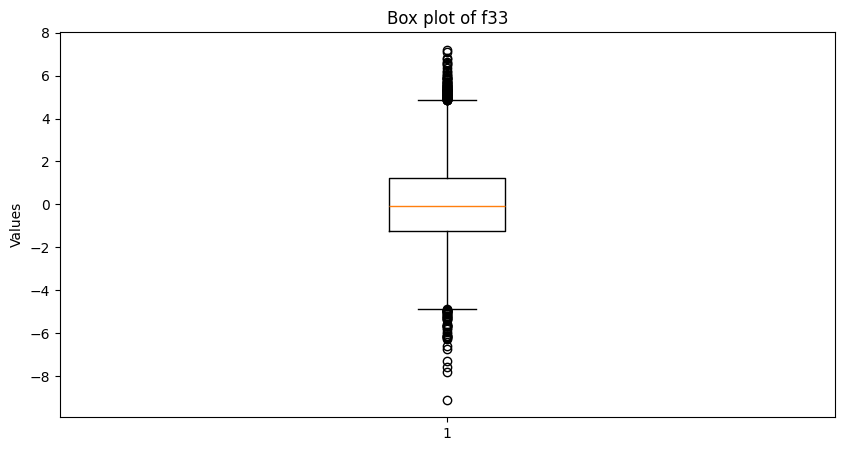

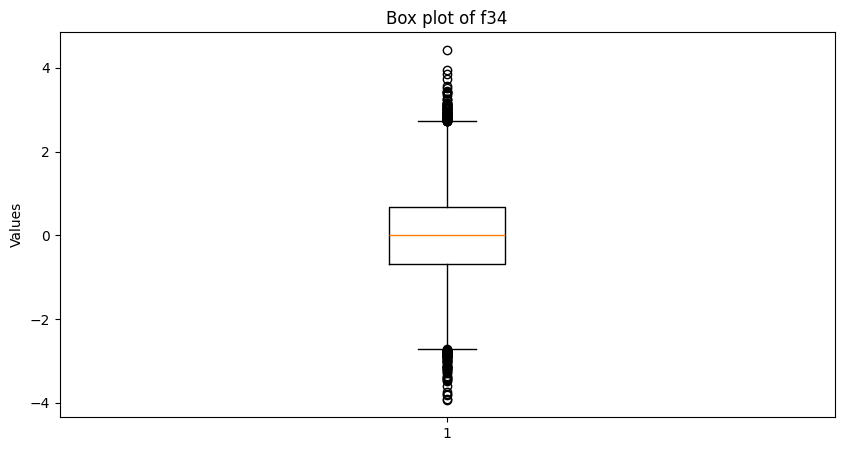

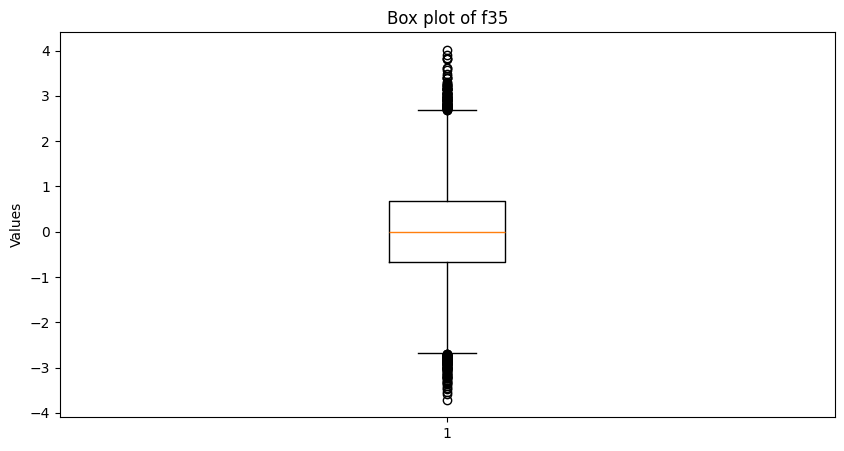

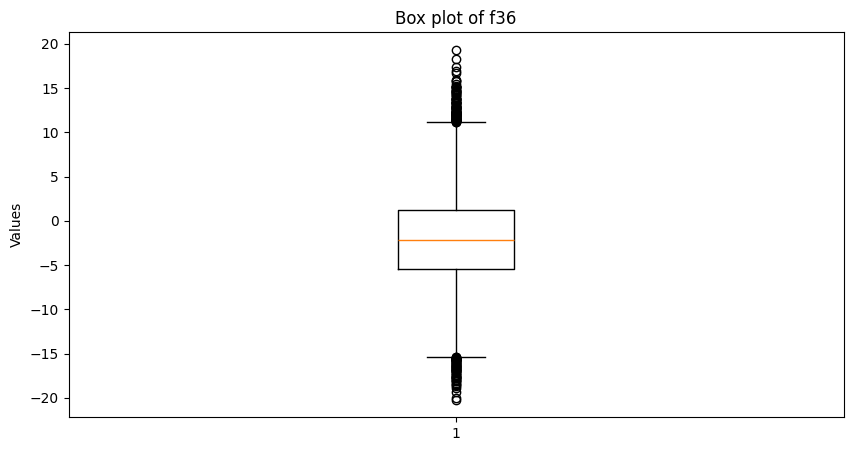

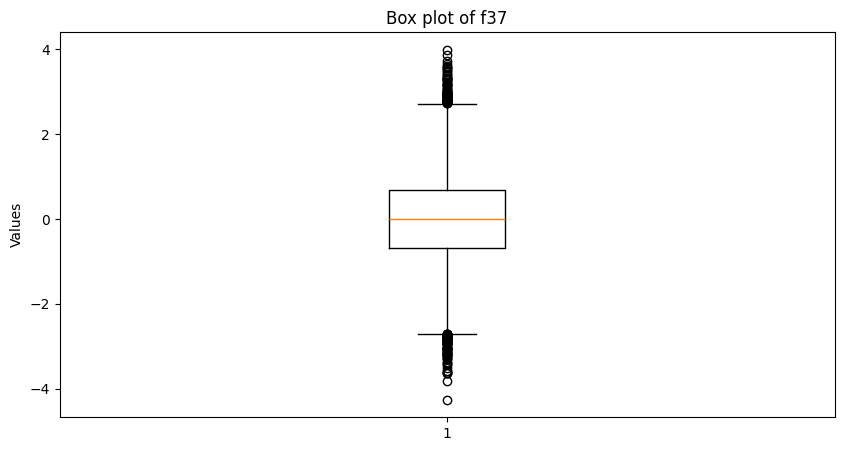

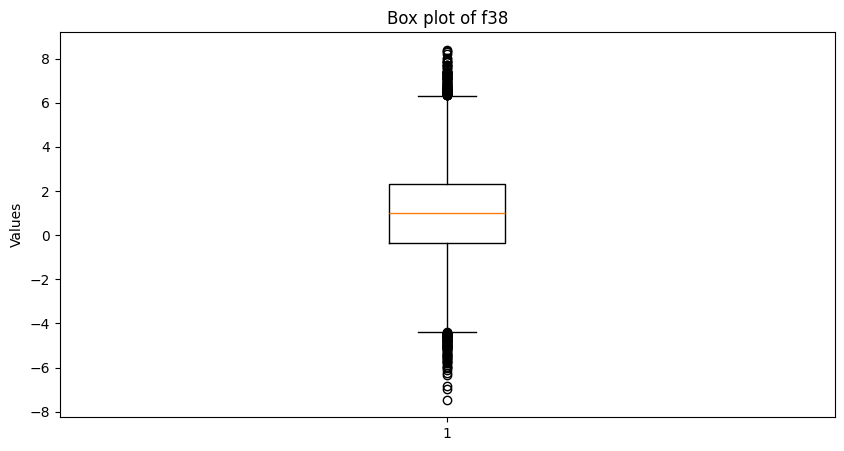

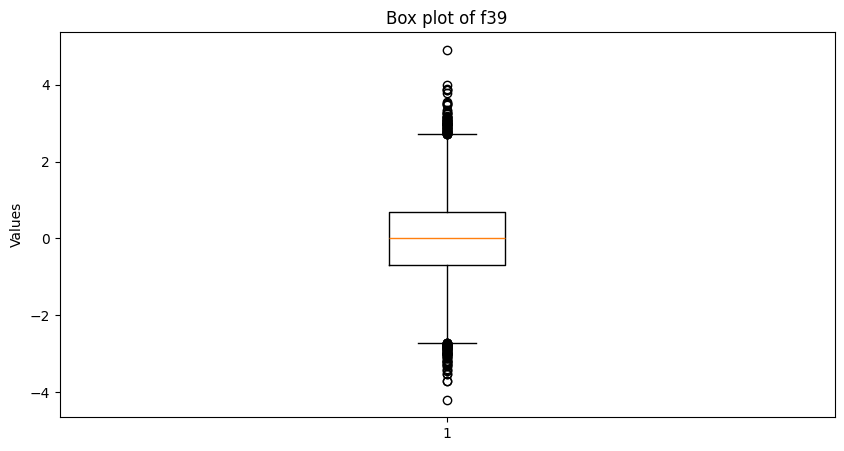

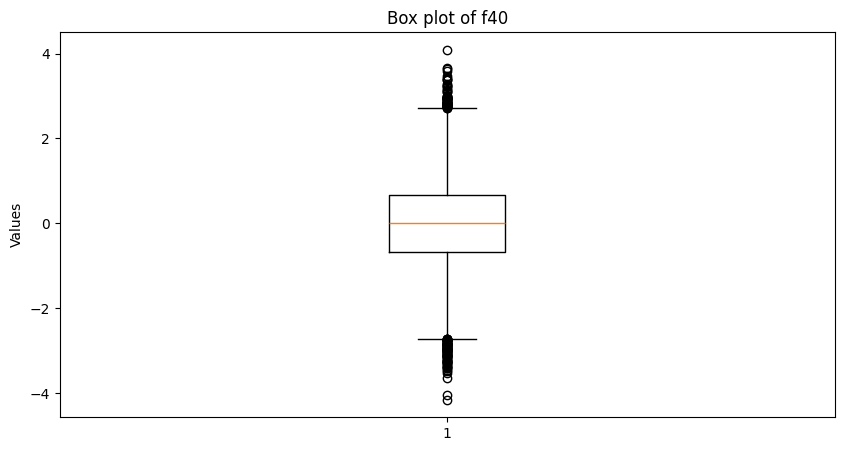

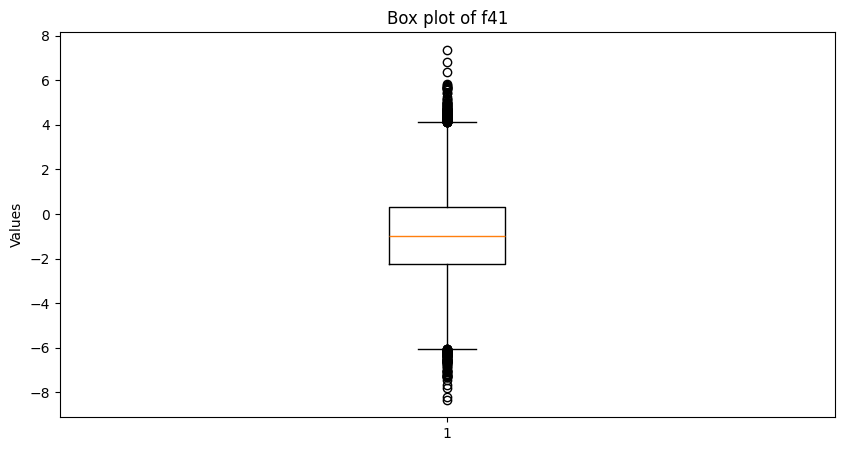

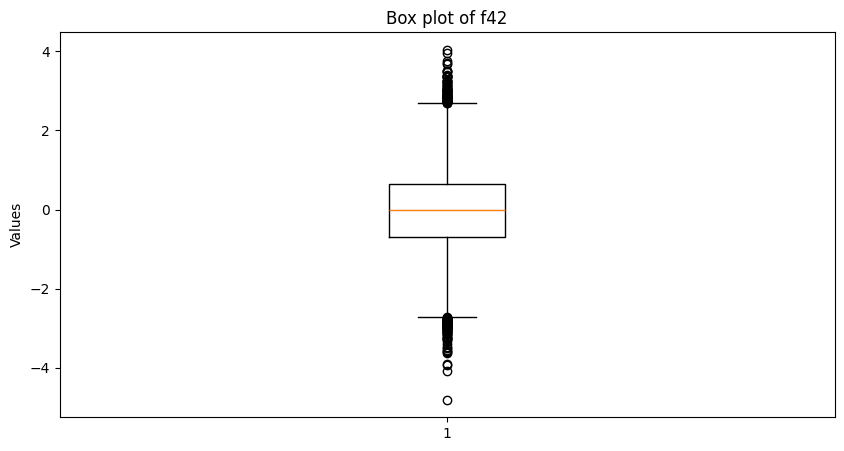

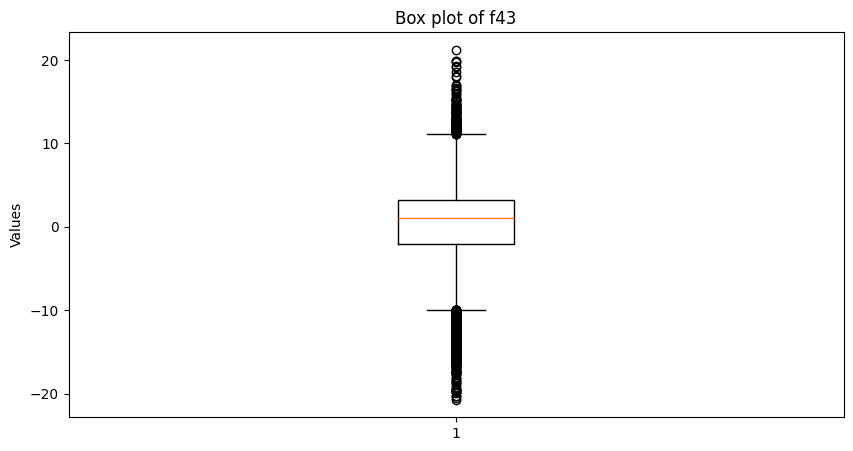

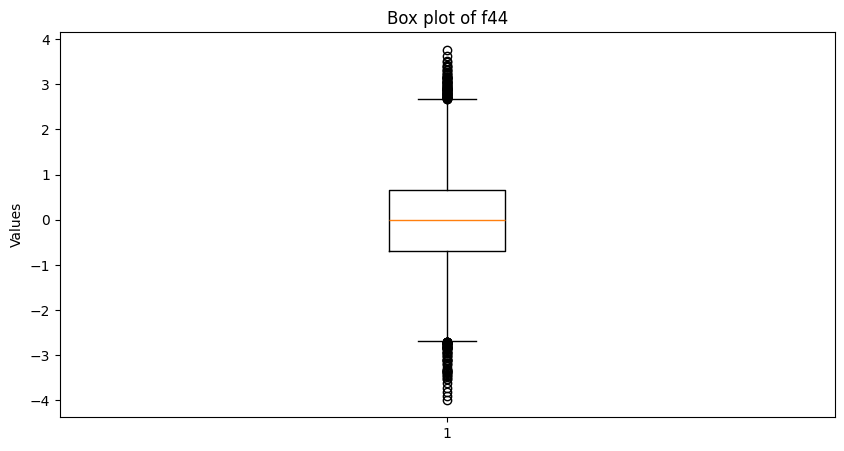

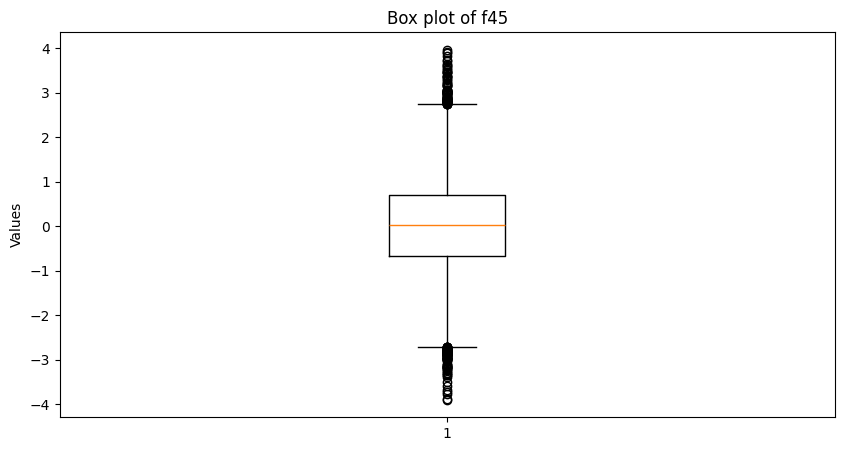

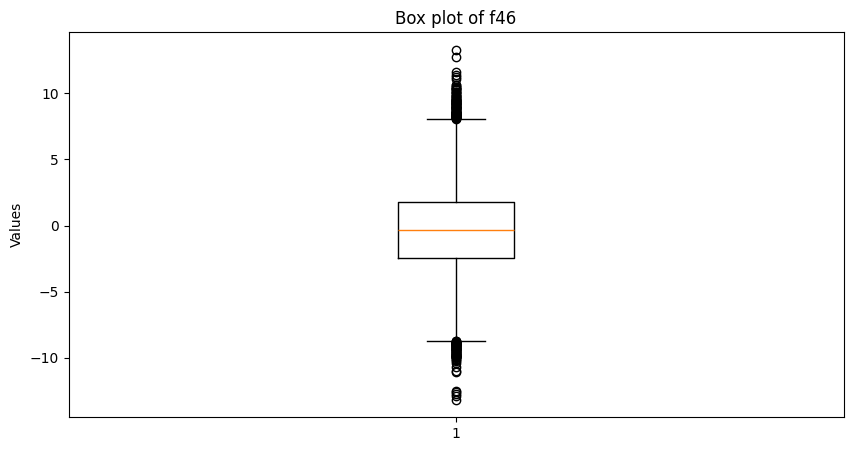

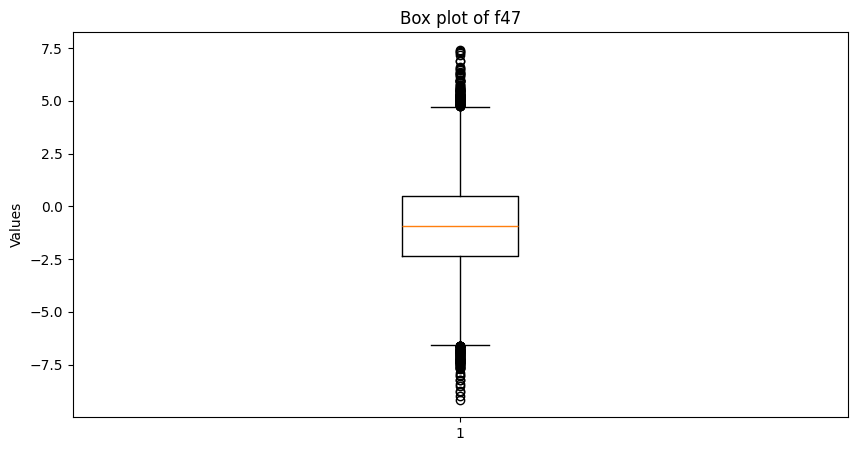

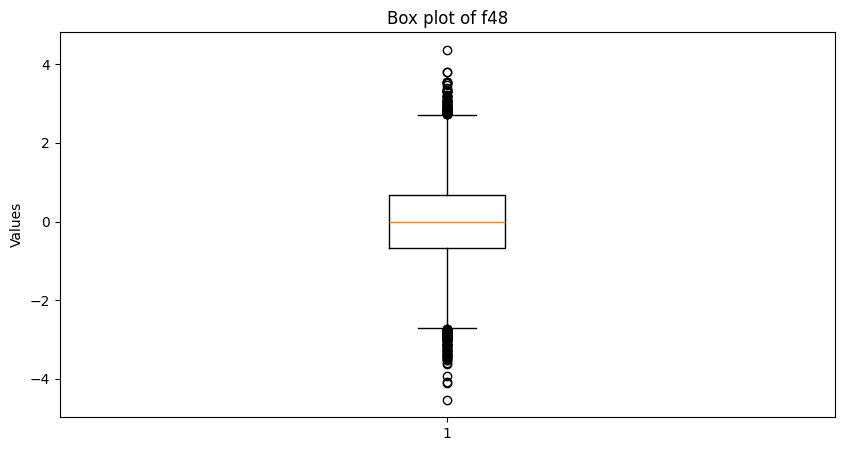

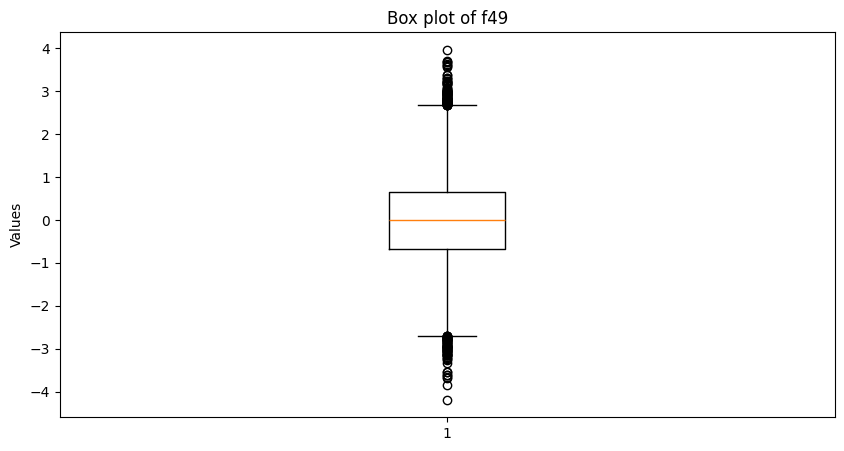

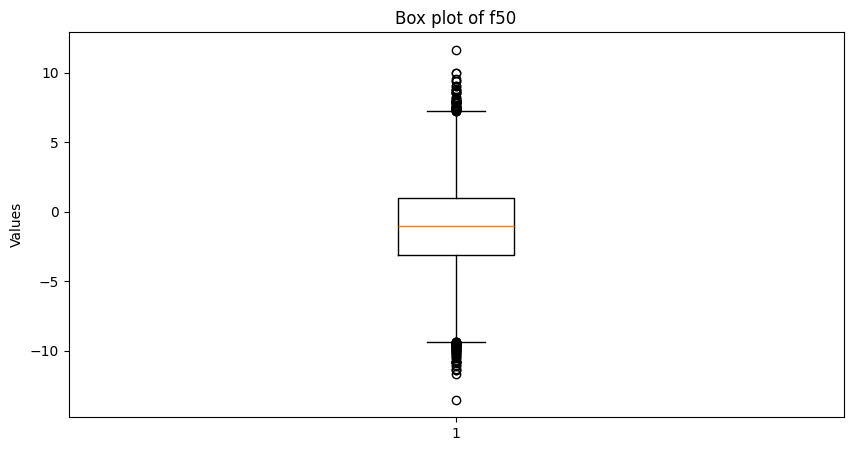

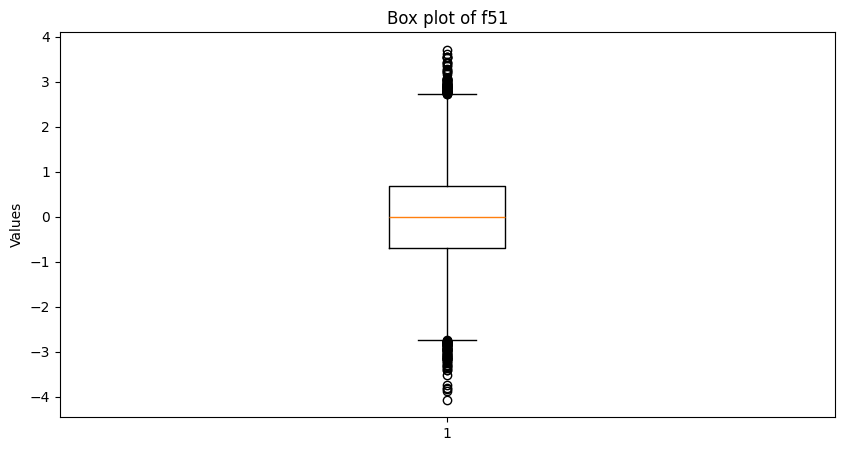

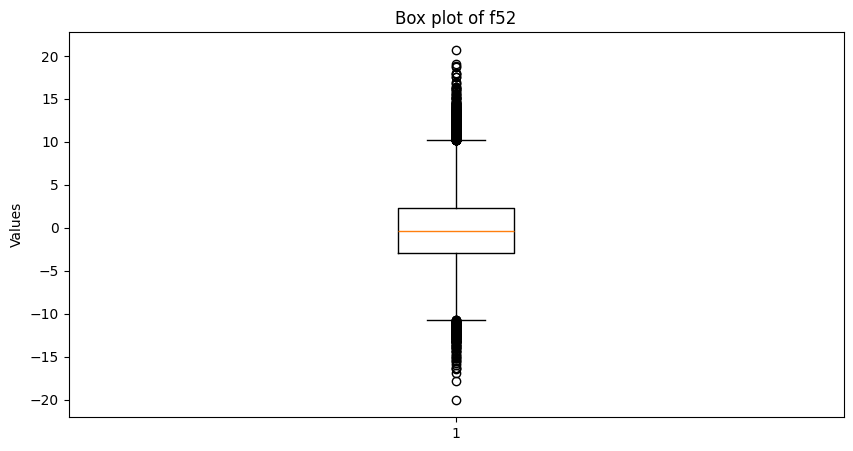

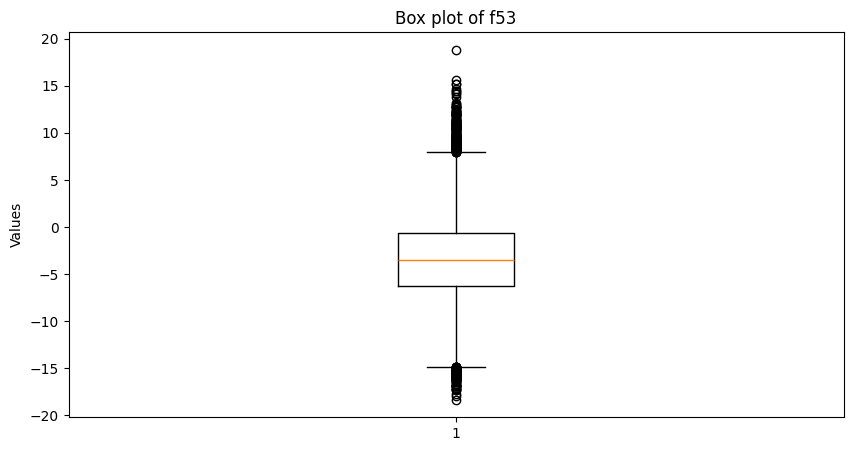

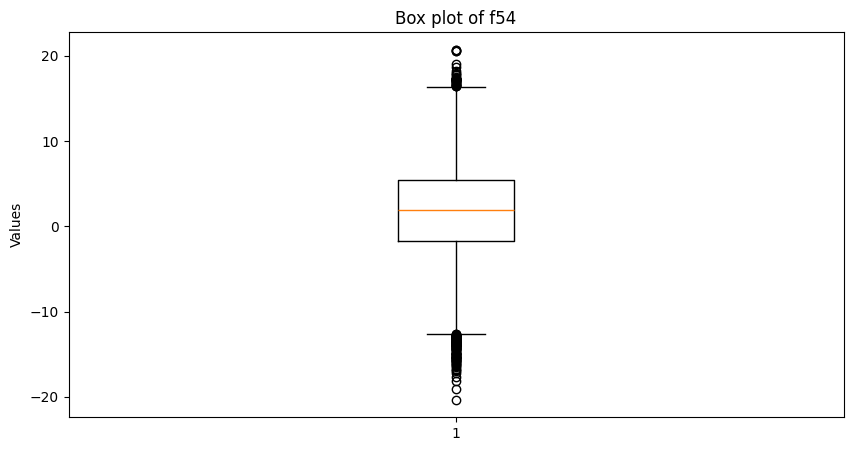

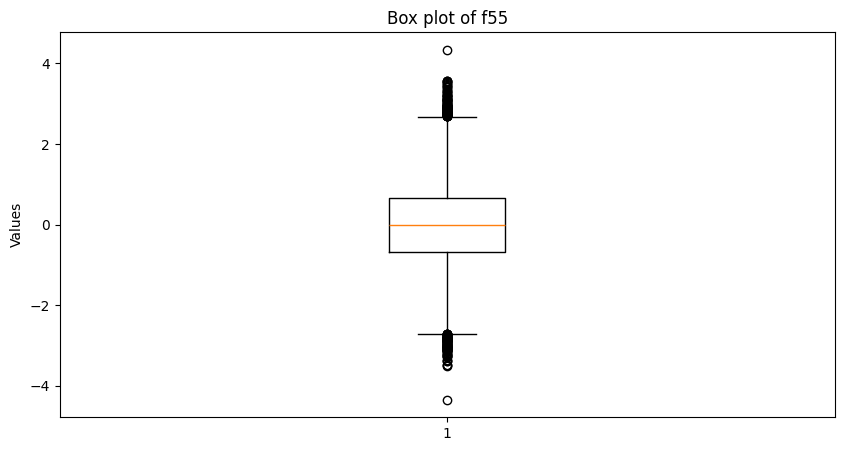

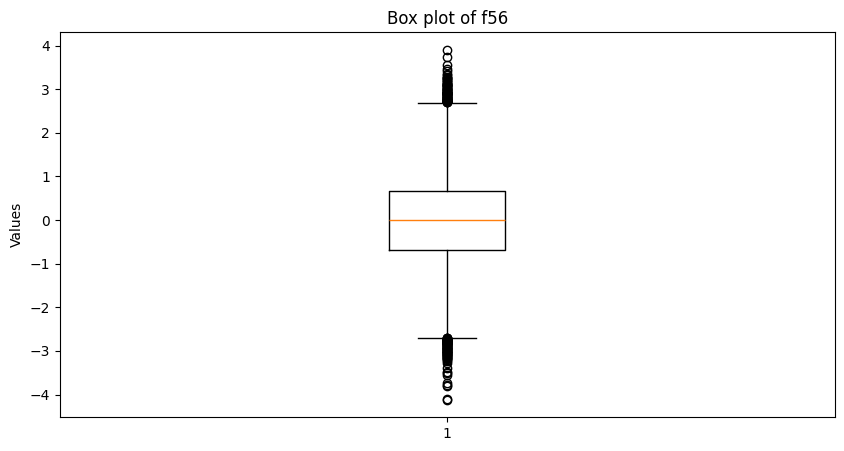

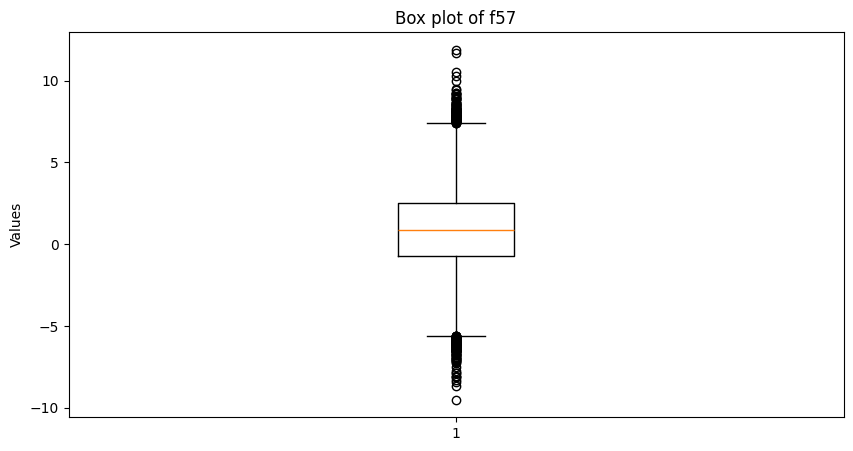

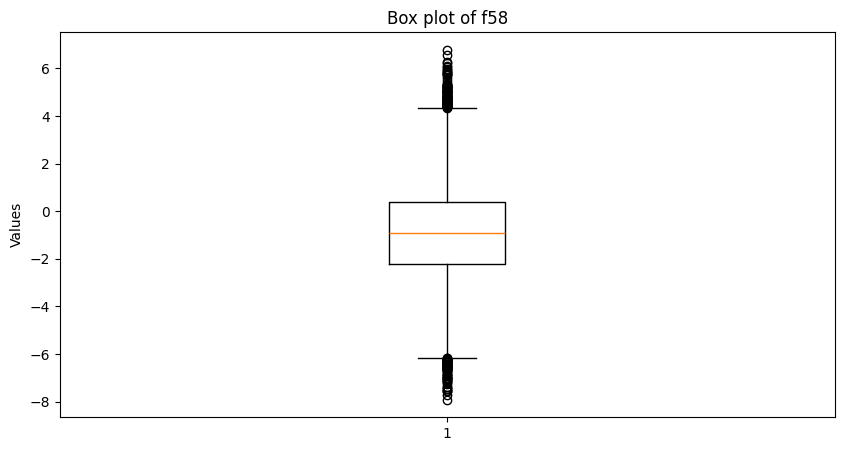

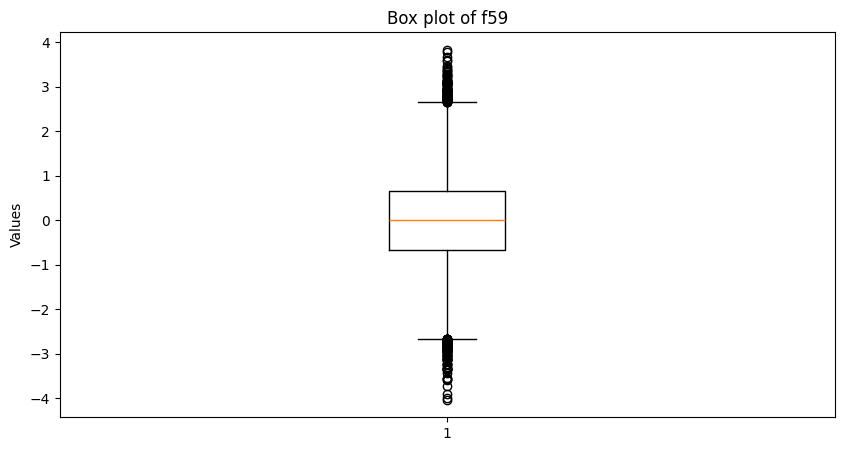

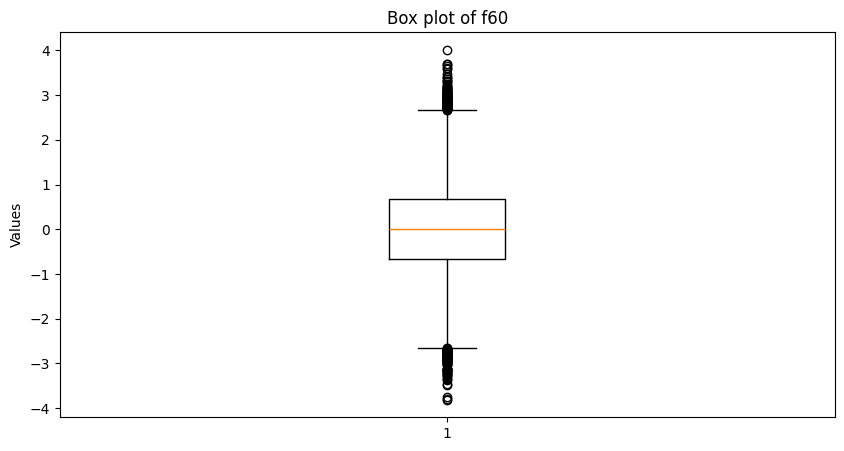

In [29]:
# Is there any outliers?
numeric_df = data.select_dtypes(include=np.number)
for column in numeric_df.columns:
	fig = plt.figure(figsize=(10, 5))
	ax = fig.add_subplot(1, 1, 1)
	ax.boxplot(numeric_df[column])
	ax.set_title(f'Box plot of {column}')
	ax.set_ylabel('Values')
	plt.savefig(FIGURES_DIR / f'box_plot_{column}.png')
	plt.show()

Вот же, судя по всему тут очень много данных с выбросами. Нужно их обработать перед обучением модели.

Заменим StandardScaler на RobustScaler, который менее чувствителен к выбросам.

In [13]:
# Okay, let's split the data
X = data.drop(columns=["target"])
y = data["target"]
feature_names = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape

((20000, 60), (5000, 60))

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_models = {}  # label -> fitted best estimator
search_summaries = {}  # label -> краткая инфа о подборе

# 2.1 Dummy baseline (без подбора)

# Dummy baseline: помогает понять, что модель вообще умеет что-то лучше «угадайки».
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(evaluate_on_test(dummy, X_test, y_test, "Dummy(most_frequent)"))
best_models["Dummy(most_frequent)"] = dummy

# 2.2 LogisticRegression baseline (с минимальным подбором)

lr = Pipeline([
    ("scaler", RobustScaler()),
    ("lr", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE))
])


# Подбираем C (обратная сила регуляризации): меньше C -> сильнее регуляризация -> проще модель.
lr_grid = {
    "lr__C": [0.1, 1.0, 10.0],
    "lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"],
}


# GridSearchCV перебирает сетку параметров и оценивает качество по CV. scoring=roc_auc – метрика для бинарной классификации по вероятностям.
lr_search = GridSearchCV(
    lr, lr_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}

results.append(evaluate_on_test(best_lr, X_test, y_test, "LogReg(scaled)"))

search_summaries["LogReg(scaled)"]

{'best_params': {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'},
 'best_cv_roc_auc': 0.8218661558557436}

In [15]:
def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

In [16]:
dt_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("dt", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

dt_grid = {
    "dt__max_depth": [None, 3, 5, 8],
    "dt__min_samples_leaf": [1, 5, 10, 20],
    "dt__ccp_alpha": [0.0, 0.001, 0.005, 0.01],
}

dt_search = run_search("DecisionTree", dt_pipeline, dt_grid)
search_summaries["DecisionTree"]

{'best_params': {'dt__ccp_alpha': 0.0,
  'dt__max_depth': None,
  'dt__min_samples_leaf': 20},
 'best_cv_roc_auc': 0.7878843520028387}

In [ ]:
rf_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        oob_score=False
    ))
])

rf_grid = {
    "rf__max_depth": [None, 6, 10],
    "rf__min_samples_leaf": [1, 5, 10],
    "rf__max_features": ["sqrt", 0.5],
}

rf_search = run_search("RandomForest", rf_pipeline, rf_grid)

In [19]:
search_summaries["RandomForest"]

{'best_params': {'rf__max_depth': None,
  'rf__max_features': 'sqrt',
  'rf__min_samples_leaf': 10},
 'best_cv_roc_auc': 0.888254139124084}

In [20]:
hgb_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("hgb", HistGradientBoostingClassifier(
        random_state=RANDOM_STATE,
        early_stopping=True
    ))
])

hgb_grid = {
    "hgb__learning_rate": [0.03, 0.05, 0.1],
    "hgb__max_depth": [2, 3, None],
    "hgb__max_leaf_nodes": [15, 31, 63],
}

hgb_search = run_search("HistGradientBoosting", hgb_pipeline, hgb_grid)
search_summaries["HistGradientBoosting"]

{'best_params': {'hgb__learning_rate': 0.03,
  'hgb__max_depth': None,
  'hgb__max_leaf_nodes': 15},
 'best_cv_roc_auc': 0.901583053970161}

In [ ]:
estimators = [
    ("lr", best_models["LogReg(scaled)"]),
    ("rf", best_models["RandomForest"]),
    ("hgb", best_models["HistGradientBoosting"]),
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=4000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stack.fit(X_train, y_train)
best_models["Stacking"] = stack
results.append(evaluate_on_test(stack, X_test, y_test, "Stacking"))

In [22]:
df = pd.DataFrame(results)

df_sorted = df.copy()
df_sorted["roc_auc_sort"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])

df_sorted

,accuracy,f1,roc_auc,model
5,0.9798,0.754258,0.813989,Stacking
4,0.9772,0.703125,0.774075,HistGradientBoosting
2,0.9672,0.590000,0.736051,DecisionTree
3,0.9684,0.529762,0.680789,RandomForest
1,0.9632,0.428571,0.639508,LogReg(scaled)
0,0.9508,0.000000,0.500000,Dummy(most_frequent)


In [23]:
metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json({"results": df_sorted.to_dict(orient="records")}, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts/metrics_test.json
Saved: artifacts/search_summaries.json


In [24]:
best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()

('Stacking',
 {'accuracy': 0.9798,
  'f1': 0.754257907542579,
  'roc_auc': 0.813988904508313,
  'model': 'Stacking'})

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished


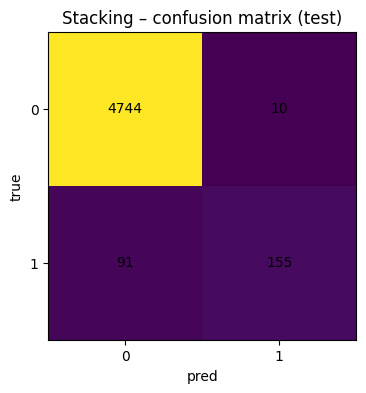

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished


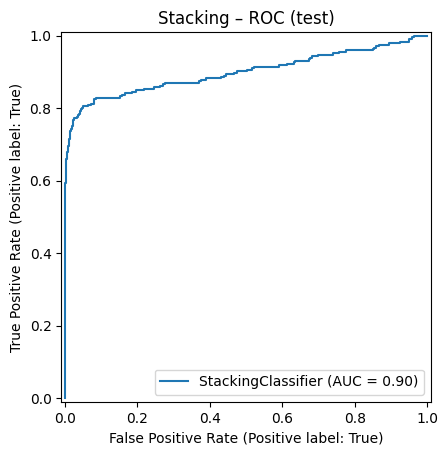

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished


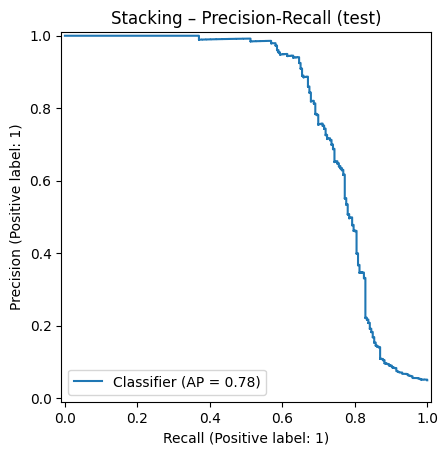

In [25]:
y_pred = best_model.predict(X_test)
plot_confusion(y_test, y_pred, title=f"{best_label} – confusion matrix (test)")
plot_roc(best_model, X_test, y_test, title=f"{best_label} – ROC (test)")
plot_pr(best_model, X_test, y_test, title=f"{best_label} – Precision-Recall (test)")

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_job

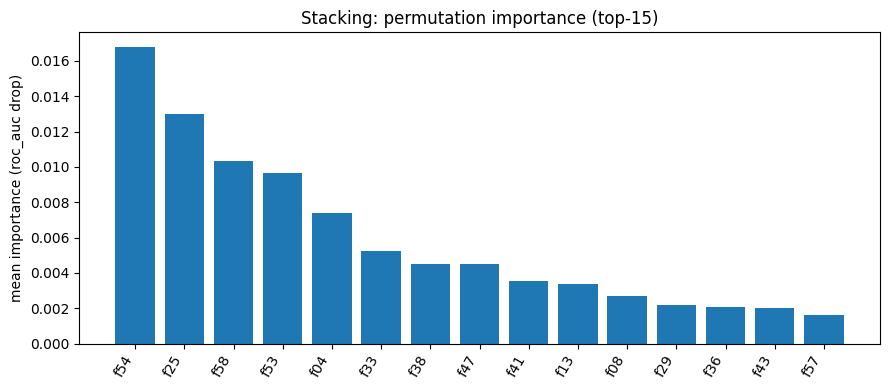

In [26]:
scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.savefig(FIGURES_DIR / f"{best_label}_permutation_importance_top15.png")
plt.show()

In [27]:
model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

print("Saved:", model_path)
print("Saved:", ARTIFACTS_DIR / "best_model_meta.json")

Saved: artifacts/best_model.joblib
Saved: artifacts/best_model_meta.json
